In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import os
import numpy as np
from torchvision import transforms
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import torch.nn as nn


In [2]:

transform = transforms.Compose([
    transforms.Grayscale(3),
    transforms.ToTensor()#,
])

In [3]:
train_set= ImageFolder(root='new_spectograms_12classes\\train', transform=transform)
test_set = ImageFolder(root='new_spectograms_12classes\\test', transform=transform)
val_set = ImageFolder(root='new_spectograms_12classes\\val', transform=transform)

# Sprawdzenie etykiet (to jest przypisanie nazw folderów do etykiet)
class_names = train_set.classes
num_labels = len(class_names)
class_names


['down',
 'go',
 'left',
 'no',
 'off',
 'on',
 'right',
 'silence',
 'stop',
 'unknown',
 'up',
 'yes']

In [4]:
import torch.nn.init as init

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Linear, nn.Conv2d)):  # Xavier dla warstw w pełni połączonych i konwolucyjnych
            init.xavier_uniform_(m.weight)  # Lub init.xavier_normal_(m.weight)
            if m.bias is not None:
                init.zeros_(m.bias)  # Biasy zerujemy

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=12):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # Zmienione z 1 na 3
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 224 -> 112
        x = self.pool(F.relu(self.conv2(x)))  # 112 -> 56
        x = self.pool(F.relu(self.conv3(x)))  # 56 -> 28
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [5]:
num_labels

12

In [15]:
model = SimpleCNN()
initialize_weights(model)
model

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=12, bias=True)
)

Dataloading...
Epoch 1, Average Loss: 1.14533, Accuracy: 62.39%, last batch accuracy: 0.00% Time: 0.01sss
Epoch 1, Train Accuracy: 62.39%
Epoch 1, Validation Loss: 0.8032, Accuracy: 73.38%
Epoch 2, Average Loss: 0.78877, Accuracy: 73.58%, last batch accuracy: 100.00% Time: 0.01s
Epoch 2, Train Accuracy: 73.58%
Epoch 2, Validation Loss: 0.6555, Accuracy: 78.75%
Epoch 3, Average Loss: 0.66077, Accuracy: 78.06%, last batch accuracy: 100.00% Time: 0.01s
Epoch 3, Train Accuracy: 78.06%
Epoch 3, Validation Loss: 0.6211, Accuracy: 79.23%
Epoch 4, Average Loss: 0.57611, Accuracy: 80.96%, last batch accuracy: 66.67% Time: 0.01ss
Epoch 4, Train Accuracy: 80.96%
Epoch 4, Validation Loss: 0.6058, Accuracy: 79.56%
Epoch 5, Average Loss: 0.49877, Accuracy: 83.12%, last batch accuracy: 100.00% Time: 0.01s
Epoch 5, Train Accuracy: 83.12%
Epoch 5, Validation Loss: 0.5680, Accuracy: 82.17%
Epoch 6, Average Loss: 0.43444, Accuracy: 85.30%, last batch accuracy: 100.00% Time: 0.01s
Epoch 6, Train Accuracy:

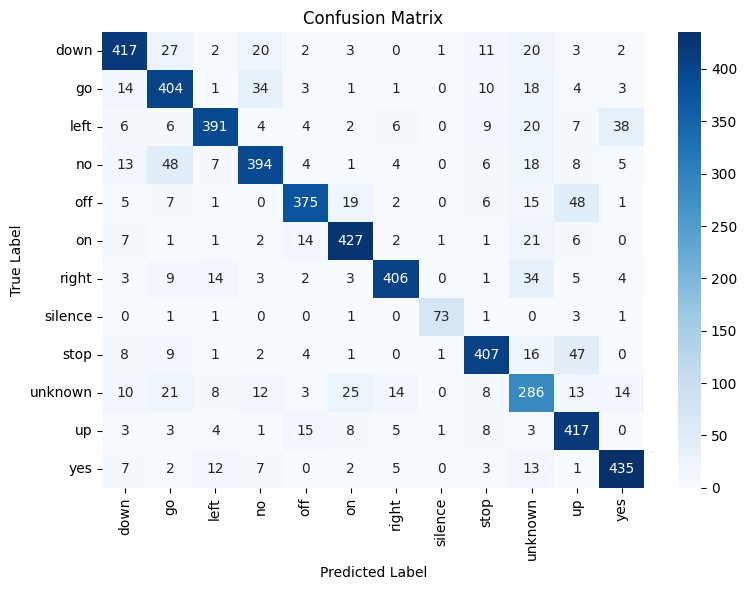

In [16]:

import time

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Jeśli używasz CUDA, ustaw również seed dla GPU
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Dla wszystkich urządzeń CUDA
    torch.backends.cudnn.deterministic = True  # Zapewnia deterministyczność
    torch.backends.cudnn.benchmark = True

print('Dataloading...')
data_loader = DataLoader(train_set, batch_size=16, num_workers=6, generator=torch.Generator(device='cpu'),pin_memory=True, shuffle=True,persistent_workers=True, prefetch_factor=4)
data_loader_val =  DataLoader(val_set, batch_size=16, num_workers=4, generator=torch.Generator(device='cpu'), persistent_workers=True, prefetch_factor=2)

#data_loader_val = DataLoader(val_set, batch_size=16, num_workers=2,persistent_workers=True, generator=torch.Generator(device='cpu'))

# Accessing the model configuration


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

previous_time = time.time()
for epoch in range(20):  # Liczba epok
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    previous_time = time.time()
    for i, (batch_X, batch_Y) in enumerate(data_loader):
        X = batch_X.to(device, non_blocking=True)  # <-- Przesyłanie X na odpowiednie urządzenie
        Y = batch_Y.to(device, non_blocking=True)  # <-- Przesyłanie Y na odpowiednie urządzenie
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()     
        optimizer.step()


        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == Y).sum().item()
        total += Y.size(0)
        
        print(f"Epoch {epoch + 1}, i: {i}, Loss: {total_loss / (i+1):.4f}, Accuracy: {correct / total * 100:.2f}%, last batch accuracy: {(predicted == Y).sum().item()/Y.size(0) * 100:.2f}% Time: {time.time() - previous_time:.2f}s", end='\r')
        previous_time = time.time()

    # Obliczenie średniego straty na epokę
    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")
    train_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Train Accuracy: {train_accuracy:.2f}%")

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_Y in data_loader_val:
            X = batch_X.to(device, non_blocking=True)
            Y = batch_Y.to(device, non_blocking=True)
            outputs = model(X)
            loss = criterion(outputs, Y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == Y).sum().item()
            total += Y.size(0)
    avg_val_loss = val_loss / len(data_loader_val)
    val_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

# 6. Ewaluacja
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():  # Wyłączenie śledzenia gradientów
    data_loader_test = DataLoader(test_set, batch_size=16, num_workers=2, persistent_workers=True, generator=torch.Generator(device='cpu'))
    total = 0
    correct = 0
    for images, labels in data_loader_test:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Zbieranie predykcji i prawdziwych etykiet
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Precision i Recall per klasa
    precision_per_class = precision_score(all_labels, all_predictions, average=None, zero_division=0)
    recall_per_class = recall_score(all_labels, all_predictions, average=None, zero_division=0)

    # Pobierz nazwy klas
    classes = test_set.classes if hasattr(test_set, 'classes') else list(set(all_labels))

    # Tabelka z wynikami
    df_metrics = pd.DataFrame({
        'Class': classes,
        'Precision': precision_per_class,
        'Recall': recall_per_class
    })

    print("\nPrecision and Recall per class:")
    print(df_metrics.to_string(index=False))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

In [17]:
model = SimpleCNN()
model

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=12, bias=True)
)

Dataloading...
Epoch 1, Average Loss: 1.38800, Accuracy: 54.08%, last batch accuracy: 0.00% Time: 0.01ss
Epoch 1, Train Accuracy: 54.08%
Epoch 1, Validation Loss: 0.9421, Accuracy: 69.85%
Epoch 2, Average Loss: 0.95633, Accuracy: 68.70%, last batch accuracy: 66.67% Time: 0.01ss
Epoch 2, Train Accuracy: 68.70%
Epoch 2, Validation Loss: 0.7838, Accuracy: 74.04%
Epoch 3, Average Loss: 0.82844, Accuracy: 72.59%, last batch accuracy: 33.33% Time: 0.01s
Epoch 3, Train Accuracy: 72.59%
Epoch 3, Validation Loss: 0.7170, Accuracy: 76.80%
Epoch 4, Average Loss: 0.74844, Accuracy: 75.07%, last batch accuracy: 66.67% Time: 0.01ss
Epoch 4, Train Accuracy: 75.07%
Epoch 4, Validation Loss: 0.6625, Accuracy: 77.65%
Epoch 5, Average Loss: 0.67011, Accuracy: 77.38%, last batch accuracy: 66.67% Time: 0.01s
Epoch 5, Train Accuracy: 77.38%
Epoch 5, Validation Loss: 0.6593, Accuracy: 77.83%
Epoch 6, Average Loss: 0.61055, Accuracy: 79.21%, last batch accuracy: 100.00% Time: 0.01s
Epoch 6, Train Accuracy: 79

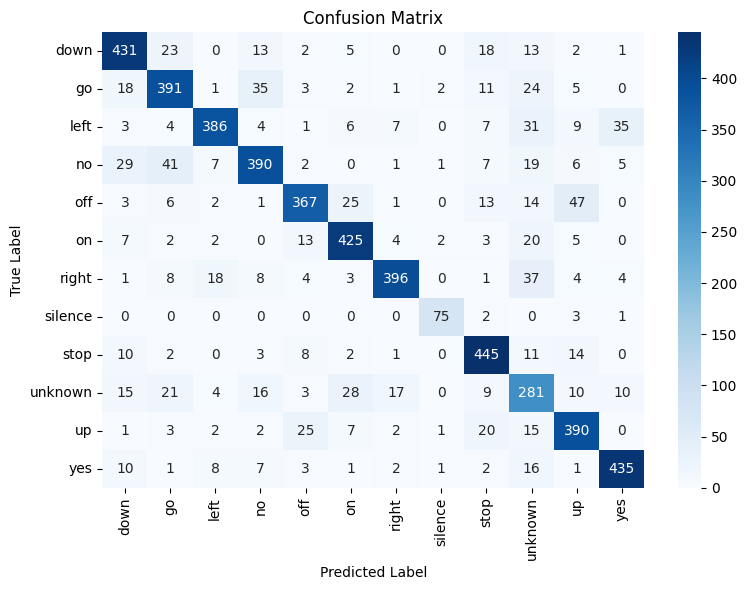

In [18]:

import time

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Jeśli używasz CUDA, ustaw również seed dla GPU
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Dla wszystkich urządzeń CUDA
    torch.backends.cudnn.deterministic = True  # Zapewnia deterministyczność
    torch.backends.cudnn.benchmark = True

print('Dataloading...')
data_loader = DataLoader(train_set, batch_size=16, num_workers=6, generator=torch.Generator(device='cpu'),pin_memory=True, shuffle=True,persistent_workers=True, prefetch_factor=4)
data_loader_val =  DataLoader(val_set, batch_size=16, num_workers=4, generator=torch.Generator(device='cpu'), persistent_workers=True, prefetch_factor=2)

#data_loader_val = DataLoader(val_set, batch_size=16, num_workers=2,persistent_workers=True, generator=torch.Generator(device='cpu'))

# Accessing the model configuration


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

previous_time = time.time()
for epoch in range(20):  # Liczba epok
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    previous_time = time.time()
    for i, (batch_X, batch_Y) in enumerate(data_loader):
        X = batch_X.to(device, non_blocking=True)  # <-- Przesyłanie X na odpowiednie urządzenie
        Y = batch_Y.to(device, non_blocking=True)  # <-- Przesyłanie Y na odpowiednie urządzenie
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()     
        optimizer.step()


        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == Y).sum().item()
        total += Y.size(0)
        
        print(f"Epoch {epoch + 1}, i: {i}, Loss: {total_loss / (i+1):.4f}, Accuracy: {correct / total * 100:.2f}%, last batch accuracy: {(predicted == Y).sum().item()/Y.size(0) * 100:.2f}% Time: {time.time() - previous_time:.2f}s", end='\r')
        previous_time = time.time()

    # Obliczenie średniego straty na epokę
    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")
    train_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Train Accuracy: {train_accuracy:.2f}%")

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_Y in data_loader_val:
            X = batch_X.to(device, non_blocking=True)
            Y = batch_Y.to(device, non_blocking=True)
            outputs = model(X)
            loss = criterion(outputs, Y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == Y).sum().item()
            total += Y.size(0)
    avg_val_loss = val_loss / len(data_loader_val)
    val_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

# 6. Ewaluacja
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():  # Wyłączenie śledzenia gradientów
    data_loader_test = DataLoader(test_set, batch_size=16, num_workers=2, persistent_workers=True, generator=torch.Generator(device='cpu'))
    total = 0
    correct = 0
    for images, labels in data_loader_test:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Zbieranie predykcji i prawdziwych etykiet
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Precision i Recall per klasa
    precision_per_class = precision_score(all_labels, all_predictions, average=None, zero_division=0)
    recall_per_class = recall_score(all_labels, all_predictions, average=None, zero_division=0)

    # Pobierz nazwy klas
    classes = test_set.classes if hasattr(test_set, 'classes') else list(set(all_labels))

    # Tabelka z wynikami
    df_metrics = pd.DataFrame({
        'Class': classes,
        'Precision': precision_per_class,
        'Recall': recall_per_class
    })

    print("\nPrecision and Recall per class:")
    print(df_metrics.to_string(index=False))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

In [5]:
from torchvision.models import vit_b_16
model = vit_b_16()

In [6]:

model.heads.head = nn.Linear(model.heads.head.in_features, 12)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
initialize_weights(model)
model.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

Dataloading...
Epoch 1, Average Loss: 1.79677, Accuracy: 39.87%, last batch accuracy: 0.00% Time: 0.52ss
Epoch 1, Train Accuracy: 39.87%
Epoch 1, Validation Loss: 1.2897, Accuracy: 56.14%
Epoch 2, Average Loss: 1.19011, Accuracy: 60.32%, last batch accuracy: 66.67% Time: 0.28s
Epoch 2, Train Accuracy: 60.32%
Epoch 2, Validation Loss: 1.0980, Accuracy: 61.47%
Epoch 3, Average Loss: 1.03700, Accuracy: 65.30%, last batch accuracy: 66.67% Time: 0.28s
Epoch 3, Train Accuracy: 65.30%
Epoch 3, Validation Loss: 0.9876, Accuracy: 66.69%
Epoch 4, Average Loss: 0.95244, Accuracy: 67.80%, last batch accuracy: 66.67% Time: 0.28s
Epoch 4, Train Accuracy: 67.80%
Epoch 4, Validation Loss: 0.9282, Accuracy: 68.24%
Epoch 5, Average Loss: 0.88711, Accuracy: 69.89%, last batch accuracy: 33.33% Time: 0.28s
Epoch 5, Train Accuracy: 69.89%
Epoch 5, Validation Loss: 0.9921, Accuracy: 67.06%
Epoch 6, Average Loss: 0.82833, Accuracy: 72.09%, last batch accuracy: 100.00% Time: 0.28s
Epoch 6, Train Accuracy: 72.0

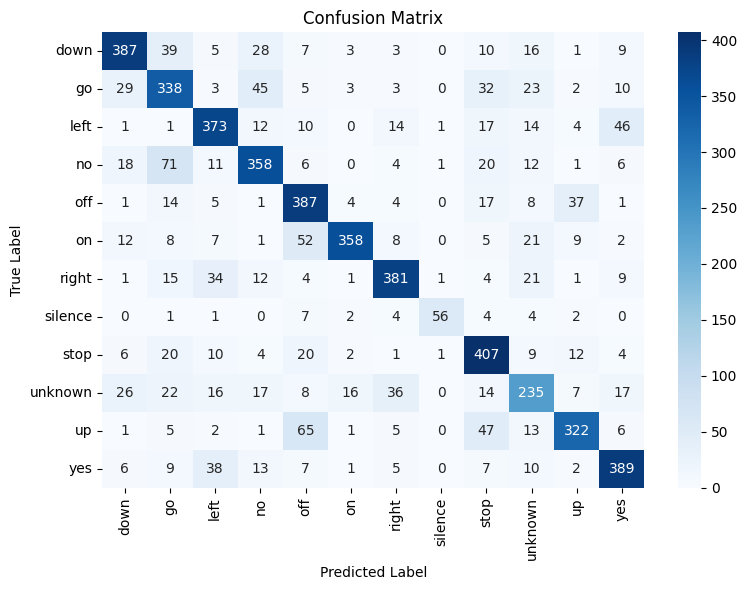

In [7]:

import time

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Jeśli używasz CUDA, ustaw również seed dla GPU
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Dla wszystkich urządzeń CUDA
    torch.backends.cudnn.deterministic = True  # Zapewnia deterministyczność
    torch.backends.cudnn.benchmark = True

print('Dataloading...')
data_loader = DataLoader(train_set, batch_size=16, num_workers=6, generator=torch.Generator(device='cpu'),pin_memory=True, shuffle=True,persistent_workers=True, prefetch_factor=4)
data_loader_val =  DataLoader(val_set, batch_size=16, num_workers=4, generator=torch.Generator(device='cpu'), persistent_workers=True, prefetch_factor=2)

#data_loader_val = DataLoader(val_set, batch_size=16, num_workers=2,persistent_workers=True, generator=torch.Generator(device='cpu'))

# Accessing the model configuration


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

previous_time = time.time()
for epoch in range(20):  # Liczba epok
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    previous_time = time.time()
    for i, (batch_X, batch_Y) in enumerate(data_loader):
        X = batch_X.to(device, non_blocking=True)  # <-- Przesyłanie X na odpowiednie urządzenie
        Y = batch_Y.to(device, non_blocking=True)  # <-- Przesyłanie Y na odpowiednie urządzenie
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()     
        optimizer.step()


        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == Y).sum().item()
        total += Y.size(0)
        
        print(f"Epoch {epoch + 1}, i: {i}, Loss: {total_loss / (i+1):.4f}, Accuracy: {correct / total * 100:.2f}%, last batch accuracy: {(predicted == Y).sum().item()/Y.size(0) * 100:.2f}% Time: {time.time() - previous_time:.2f}s", end='\r')
        previous_time = time.time()

    # Obliczenie średniego straty na epokę
    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")
    train_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Train Accuracy: {train_accuracy:.2f}%")

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_Y in data_loader_val:
            X = batch_X.to(device, non_blocking=True)
            Y = batch_Y.to(device, non_blocking=True)
            outputs = model(X)
            loss = criterion(outputs, Y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == Y).sum().item()
            total += Y.size(0)
    avg_val_loss = val_loss / len(data_loader_val)
    val_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

# 6. Ewaluacja
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():  # Wyłączenie śledzenia gradientów
    data_loader_test = DataLoader(test_set, batch_size=16, num_workers=2, persistent_workers=True, generator=torch.Generator(device='cpu'))
    total = 0
    correct = 0
    for images, labels in data_loader_test:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Zbieranie predykcji i prawdziwych etykiet
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Precision i Recall per klasa
    precision_per_class = precision_score(all_labels, all_predictions, average=None, zero_division=0)
    recall_per_class = recall_score(all_labels, all_predictions, average=None, zero_division=0)

    # Pobierz nazwy klas
    classes = test_set.classes if hasattr(test_set, 'classes') else list(set(all_labels))

    # Tabelka z wynikami
    df_metrics = pd.DataFrame({
        'Class': classes,
        'Precision': precision_per_class,
        'Recall': recall_per_class
    })

    print("\nPrecision and Recall per class:")
    print(df_metrics.to_string(index=False))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

In [19]:

import timm
import torch.nn as nn
model3 = timm.create_model("deit_tiny_patch16_224")

model3.head = nn.Linear(model3.head.in_features, 12)  # Resetowanie klasyfikatora

initialize_weights(model3)  # Xavier na nowej warstwie

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model1.to(device)

D:\anaconda\envs\torch_envi\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataloading...
Epoch 1, Average Loss: 1.82977, Accuracy: 36.85%, last batch accuracy: 0.00% Time: 0.10ss
Epoch 1, Train Accuracy: 36.85%
Epoch 1, Validation Loss: 1.1595, Accuracy: 59.89%
Epoch 2, Average Loss: 1.06111, Accuracy: 64.30%, last batch accuracy: 33.33% Time: 0.04s
Epoch 2, Train Accuracy: 64.30%
Epoch 2, Validation Loss: 0.9736, Accuracy: 66.18%
Epoch 3, Average Loss: 0.89411, Accuracy: 69.98%, last batch accuracy: 66.67% Time: 0.03ss
Epoch 3, Train Accuracy: 69.98%
Epoch 3, Validation Loss: 0.8715, Accuracy: 70.22%
Epoch 4, Average Loss: 0.81011, Accuracy: 72.75%, last batch accuracy: 66.67% Time: 0.03s
Epoch 4, Train Accuracy: 72.75%
Epoch 4, Validation Loss: 0.8157, Accuracy: 72.43%
Epoch 5, Average Loss: 0.73100, Accuracy: 75.39%, last batch accuracy: 66.67% Time: 0.03s
Epoch 5, Train Accuracy: 75.39%
Epoch 5, Validation Loss: 0.8206, Accuracy: 71.80%
Epoch 6, Average Loss: 0.67055, Accuracy: 77.08%, last batch accuracy: 100.00% Time: 0.03s
Epoch 6, Train Accuracy: 77.

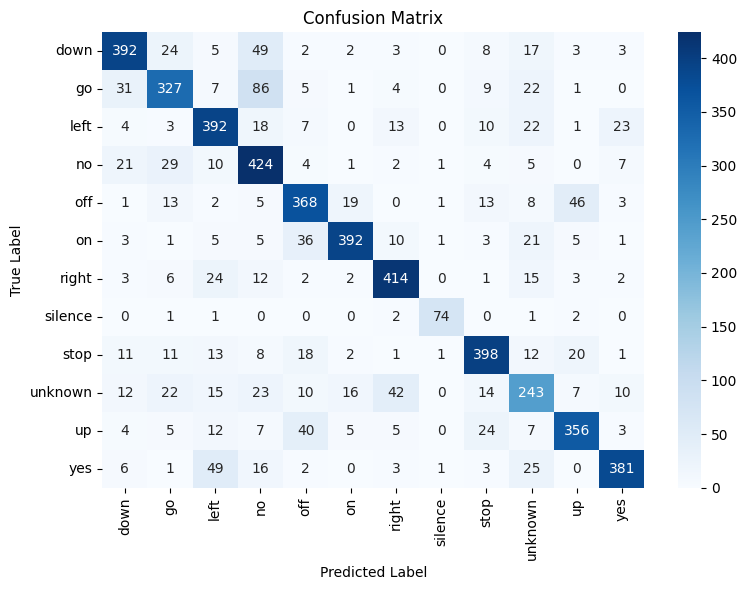

In [20]:

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Jeśli używasz CUDA, ustaw również seed dla GPU
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Dla wszystkich urządzeń CUDA
    torch.backends.cudnn.deterministic = True  # Zapewnia deterministyczność
    torch.backends.cudnn.benchmark = True

print('Dataloading...')
data_loader = DataLoader(train_set, batch_size=16, num_workers=6, generator=torch.Generator(device='cpu'),pin_memory=True, shuffle=True,persistent_workers=True, prefetch_factor=4)
data_loader_val =  DataLoader(val_set, batch_size=16, num_workers=4, generator=torch.Generator(device='cpu'), persistent_workers=True, prefetch_factor=2)

#data_loader_val = DataLoader(val_set, batch_size=16, num_workers=2,persistent_workers=True, generator=torch.Generator(device='cpu'))

# Accessing the model configuration


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3.to(device)
optimizer = torch.optim.AdamW(model3.parameters(), lr=0.00001)
criterion = torch.nn.CrossEntropyLoss()

previous_time = time.time()
for epoch in range(20):  # Liczba epok
    model3.train()
    total_loss = 0
    correct = 0
    total = 0
    previous_time = time.time()
    for i, (batch_X, batch_Y) in enumerate(data_loader):
        X = batch_X.to(device, non_blocking=True)  # <-- Przesyłanie X na odpowiednie urządzenie
        Y = batch_Y.to(device, non_blocking=True)  # <-- Przesyłanie Y na odpowiednie urządzenie
        optimizer.zero_grad()
        outputs = model3(X)
        loss = criterion(outputs, Y)
        loss.backward()     
        optimizer.step()


        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == Y).sum().item()
        total += Y.size(0)
        
        print(f"Epoch {epoch + 1}, i: {i}, Loss: {total_loss / (i+1):.4f}, Accuracy: {correct / total * 100:.2f}%, last batch accuracy: {(predicted == Y).sum().item()/Y.size(0) * 100:.2f}% Time: {time.time() - previous_time:.2f}s", end='\r')
        previous_time = time.time()

    # Obliczenie średniego straty na epokę
    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")
    train_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Train Accuracy: {train_accuracy:.2f}%")

    model3.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_Y in data_loader_val:
            X = batch_X.to(device, non_blocking=True)
            Y = batch_Y.to(device, non_blocking=True)
            outputs = model3(X)
            loss = criterion(outputs, Y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == Y).sum().item()
            total += Y.size(0)
    avg_val_loss = val_loss / len(data_loader_val)
    val_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

# Ewaluacja
model3.eval()
all_predictions = []
all_labels = []

with torch.no_grad():  # Wyłączenie śledzenia gradientów
    data_loader_test = DataLoader(test_set, batch_size=16, num_workers=2, persistent_workers=True, generator=torch.Generator(device='cpu'))
    total = 0
    correct = 0
    for images, labels in data_loader_test:
        images, labels = images.to(device), labels.to(device)
        outputs = model3(images)
        _, predicted = torch.max(outputs, 1)

        # Zbieranie predykcji i prawdziwych etykiet
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Precision i Recall per klasa
    precision_per_class = precision_score(all_labels, all_predictions, average=None, zero_division=0)
    recall_per_class = recall_score(all_labels, all_predictions, average=None, zero_division=0)

    # Pobierz nazwy klas
    classes = test_set.classes if hasattr(test_set, 'classes') else list(set(all_labels))

    # Tabelka z wynikami
    df_metrics = pd.DataFrame({
        'Class': classes,
        'Precision': precision_per_class,
        'Recall': recall_per_class
    })

    print("\nPrecision and Recall per class:")
    print(df_metrics.to_string(index=False))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()